# 项目简介

## 业务背景

下图是火花课堂的屏幕截图。在上课过程中，如果老师发现学生卡住了（或者学生告诉老师自己不能看到老师或无法操作课件），就会向技术支持提交一个**网络状况**工单。

![Alt text](screen_shot.png)


技术支持在看到这个工单后，会通过监课界面以学生视角观看课堂；如果技术支持认为*当时*学生课堂正常，就会关闭工单，并将关闭原因标注为“轻微抖动不影响上课”；否则，技术支持就会打电话给家长协助解决网络问题，并将关闭原因标注为“网络卡顿”。

前端开发告诉你，除了网络状况外，设备型号和性能也会导致操作卡顿；例如早期iPad或者低端Android运行火花课堂时也会卡顿。同时，他们也告诉你技术支持的关闭原因填写有噪音：用户当时是否卡，完全取决于技术支持监课的时机。

现在产研试图降低网络工单率。产品经理提出的一个建议是，**如果在工单提交时可以预测网络工单的关闭原因**，那么就可以在老师提交工单时在后台直接关闭预测为“轻微抖动不影响上课”的工单，而仅放行“网络卡顿”的工单。

你的同事也为你提取了一些正常课堂的数据，用作训练使用。


## 数据字典

type是你的Y数据：
- 0表示正常课堂
- 1表示产生网络工单且关闭原因为“轻微抖动不影响上课”
- 2表示产生网路工单且关闭原因为“网络卡顿”


火花课堂监控两张网络的状态。一张网络是声网，火花用它来传输音频和视频；另一张网络是game server，火花用它来传输师生间课件控制的数据。

声网的监控数据包括

- duration：通话时长，单位为秒，累计值；重置链接后清零。
- txAudioKBitrate:音频发送码率 (Kbps)，瞬时值
- rxAudioKBitrate:音频接收码率 (Kbps)，瞬时值
- txVideoKBitrate:音频发送码率 (Kbps)，瞬时值
- rxVideoKBitrate:音频接收码率 (Kbps)，瞬时值
- cpuTotalUsage:当前系统的 CPU 使用率 (%)
- cpuAppUsage:当前 App 的 CPU 使用率 (%)
- userCount: 当前频道内的用户人数
- sentFrameRate: 不重要
- sentBitrate: 不重要

客户端的game server的监控数据包括

- cpu: 上报数列的最高值
- lag: 客户端与game server的ping值
- fps: 客户端的针率
- memory_free：客户端未使用
- memory_app_used
- memory_inactive:

你的同事已经帮你把工单提交前40次监控和工单提交后40次监控的数据整理好了。X_lead_Y表示性能变量X在工单提交前Y次监控的数据；X_lag_Y表示性能变量X在工单提交后Y次监控的数据。X_lead_1和X_lag_1是最接近工单提交的数据。

此外，当性能数据在日志服务器上缺失时，统一填入-999

# 任务要求

## 建模

结合上述业务场景和产品需求，利用data.csv的数据，构建一个预测工单关闭原因的模型，并向产品经理和前端研发提交一个使用这个模型的产品方案。

## 汇报

在这个notebook中撰写你的报告（你也可以使用Rmarkdown）。并将你的代码也放在这个notebook中

然后向[这个Github项目](https://github.com/junchenfeng/huohua_hire)提交一个Pull Request

## 考核方面

我们考察

- 使用python生态进行数据建模的能力
- 将数据模型转化为业务生产力的能力
- 代码风格

祝你成功！

In [1]:
#读取文件
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
data = pd.read_csv("data.csv")
print(data.shape)
data.head()

(5000, 1281)


,type,txAudioKBitrate_lead_1,txAudioKBitrate_lead_2,txAudioKBitrate_lead_3,txAudioKBitrate_lead_4,txAudioKBitrate_lead_5,txAudioKBitrate_lead_6,txAudioKBitrate_lead_7,txAudioKBitrate_lead_8,txAudioKBitrate_lead_9,...,memory_inactive_lag_31,memory_inactive_lag_32,memory_inactive_lag_33,memory_inactive_lag_34,memory_inactive_lag_35,memory_inactive_lag_36,memory_inactive_lag_37,memory_inactive_lag_38,memory_inactive_lag_39,memory_inactive_lag_40
0,0,54,53.0,53.0,54.0,53.0,53.0,53.0,52.0,54.0,...,554680320.0,556302336.0,554041344.0,556220416.0,560152576.0,561233920.0,560857088.0,554582016.0,554614784.0,554598400.0
1,0,54,53.0,53.0,53.0,54.0,53.0,53.0,53.0,53.0,...,523796480.0,525516800.0,527368192.0,527826944.0,527974400.0,527728640.0,529203200.0,531628032.0,530579456.0,527695872.0
2,0,53,53.0,53.0,53.0,52.0,53.0,53.0,53.0,53.0,...,655065088.0,654704640.0,653983744.0,653934592.0,653082624.0,656326656.0,654409728.0,655081472.0,655851520.0,654884864.0
3,0,53,53.0,52.0,54.0,54.0,53.0,52.0,54.0,52.0,...,-999.0,550387712.0,-999.0,551092224.0,-999.0,551010304.0,-999.0,549273600.0,-999.0,549421056.0
4,0,53,12.0,53.0,54.0,51.0,43.0,42.0,47.0,53.0,...,585465856.0,583483392.0,582746112.0,585875456.0,585482240.0,585564160.0,586432512.0,586563584.0,586448896.0,586891264.0


In [2]:
#数据概貌
data.describe()
#count行第四列等表明存在缺失值，-999值处理

,type,txAudioKBitrate_lead_1,txAudioKBitrate_lead_2,txAudioKBitrate_lead_3,txAudioKBitrate_lead_4,txAudioKBitrate_lead_5,txAudioKBitrate_lead_6,txAudioKBitrate_lead_7,txAudioKBitrate_lead_8,txAudioKBitrate_lead_9,...,memory_inactive_lag_31,memory_inactive_lag_32,memory_inactive_lag_33,memory_inactive_lag_34,memory_inactive_lag_35,memory_inactive_lag_36,memory_inactive_lag_37,memory_inactive_lag_38,memory_inactive_lag_39,memory_inactive_lag_40
count,5000.00000,5000.000000,4998.000000,4998.000000,4998.000000,4997.000000,4997.000000,4997.000000,4994.000000,4992.000000,...,4.998000e+03,4.998000e+03,4.998000e+03,4.998000e+03,4.998000e+03,4.998000e+03,4.998000e+03,4.998000e+03,4.998000e+03,4.998000e+03
mean,0.34480,48.327200,48.554222,48.675270,48.987595,49.178507,49.400240,49.423054,49.303564,49.288061,...,5.016824e+08,5.017613e+08,5.016951e+08,5.018133e+08,5.016922e+08,5.019673e+08,5.012356e+08,5.020848e+08,5.011551e+08,5.020959e+08
std,0.70229,37.568168,37.449609,37.332675,37.184188,37.086354,36.977244,36.966075,39.819943,39.810616,...,1.080941e+08,1.078881e+08,1.082330e+08,1.082250e+08,1.082896e+08,1.077850e+08,1.092522e+08,1.074560e+08,1.091399e+08,1.070901e+08
min,0.00000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,...,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02,-9.990000e+02
25%,0.00000,50.000000,51.000000,51.000000,51.000000,51.000000,52.000000,52.000000,52.000000,52.000000,...,4.322714e+08,4.316815e+08,4.318290e+08,4.319601e+08,4.318863e+08,4.319396e+08,4.326482e+08,4.322181e+08,4.315013e+08,4.327014e+08
50%,0.00000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,...,5.047501e+08,5.045453e+08,5.049958e+08,5.051187e+08,5.041684e+08,5.047665e+08,5.048238e+08,5.047910e+08,5.044060e+08,5.046518e+08
75%,0.00000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,...,5.795676e+08,5.794734e+08,5.795103e+08,5.796086e+08,5.796618e+08,5.794161e+08,5.796086e+08,5.797233e+08,5.798257e+08,5.797069e+08
max,2.00000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,71.000000,70.000000,...,9.460122e+08,9.459794e+08,9.465037e+08,9.464873e+08,9.246310e+08,9.247621e+08,9.359852e+08,9.360015e+08,9.353789e+08,9.358377e+08


In [3]:
#查看不重复列索引
data_columns=data.columns.values
columns_0=[]
for i in range(1,1281):
    if i%40==1:
        columns_0.append(data_columns[i])
print(columns_0)

['txAudioKBitrate_lead_1', 'cpuTotalUsage_lead_1', 'rxAudioKBitrate_lead_1', 'cpuAppUsage_lead_1', 'txVideoKBitrate_lead_1', 'duration_lead_1', 'sentBitrate_lead_1', 'userCount_lead_1', 'rxVideoKBitrate_lead_1', 'sentFrameRate_lead_1', 'cpu_lead_1', 'lag_lead_1', 'fps_lead_1', 'memory_free_lead_1', 'memory_app_used_lead_1', 'memory_inactive_lead_1', 'txAudioKBitrate_lag_1', 'cpuTotalUsage_lag_1', 'rxAudioKBitrate_lag_1', 'cpuAppUsage_lag_1', 'txVideoKBitrate_lag_1', 'duration_lag_1', 'sentBitrate_lag_1', 'userCount_lag_1', 'rxVideoKBitrate_lag_1', 'sentFrameRate_lag_1', 'cpu_lag_1', 'lag_lag_1', 'fps_lag_1', 'memory_free_lag_1', 'memory_app_used_lag_1', 'memory_inactive_lag_1']


In [4]:
#删除开头为s的列
for i in range(1,1281):
    if data_columns[i][0]=='s':
        data.drop(data_columns[i],axis=1, inplace=True)
print(data.shape)
#共160列（1281-1121=160）

(5000, 1121)


In [5]:
#删除缺失值和-999值
data=data.sort_values(by="type").reset_index(drop = True)
df=data.copy()  
a_col=df.columns.values
for i in range(1,1121):
    nna=len(df[df[a_col[i]].isin([-999])])
    if nna>0:
        df=df[~df[a_col[i]].isin([-999])]
df.dropna(axis=0, how='any',inplace=False)
df=df.reset_index(drop = True)
print(df.shape)
#删除占比104/5000==2.08%

(4896, 1121)


In [6]:
#变换'type'类型为'class'，type=1认为0,type=2认为1,二分类
df['class']=0
df.loc[df['type'] == 1,'class'] = 0
df.loc[df['type'] == 2,'class'] = 1

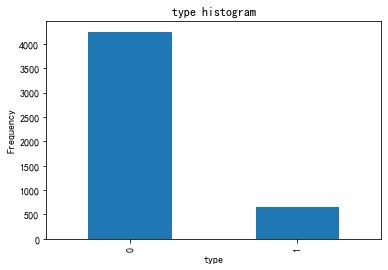

In [7]:
#将数据分成2类：0（正常数据），1（异常数据），看分布
type = pd.value_counts(df['class'], sort=True).sort_index()# 查看该列有多少种不同的属性值
type.plot(kind = 'bar')
# 作图
plt.title('type histogram')# 标题
plt.xlabel('type')# x轴添加文字
plt.ylabel('Frequency')# y轴添加文字
plt.show()

d:\al\python\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Support for uppercase single-letter colors is deprecated since Matplotlib 3.1 and will be removed in 3.3; please use lowercase instead.
  if __name__ == '__main__':


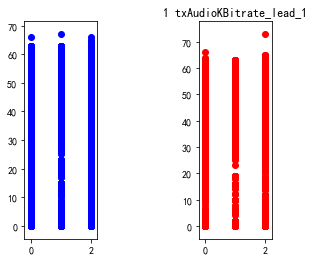

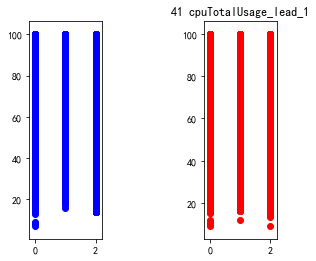

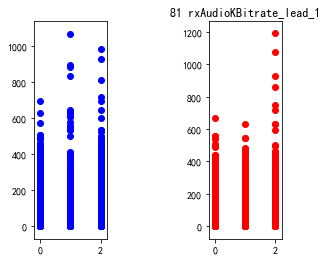

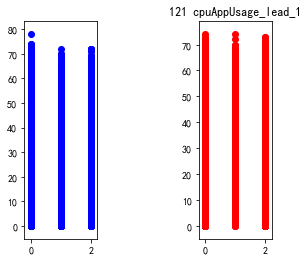

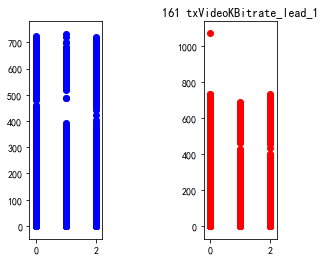

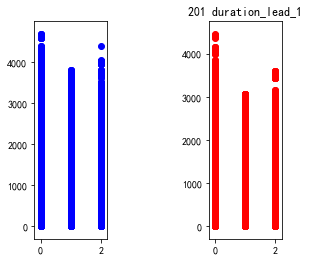

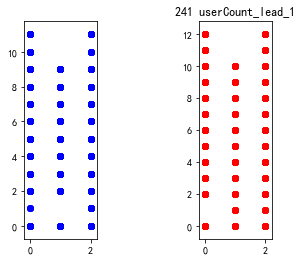

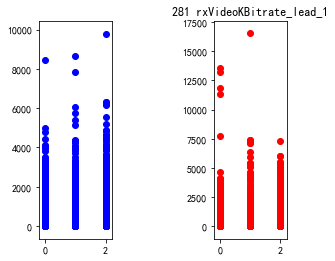

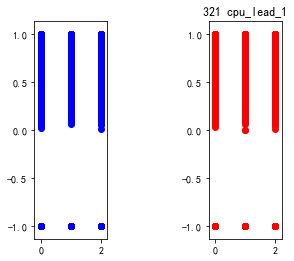

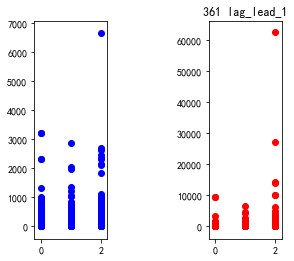

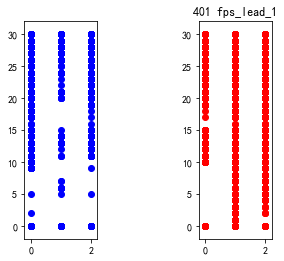

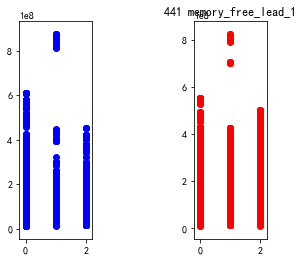

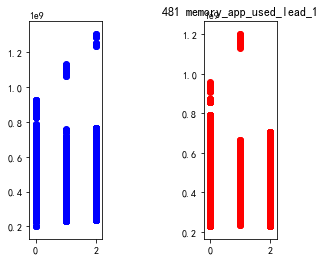

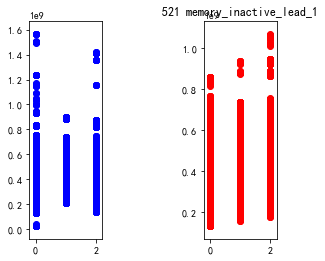

In [8]:
#看前后40秒不同类(3)数据趋势
for i in range(1,561):
    if i%40==1:
        plt.subplot(141)
        for j in range(0,40):
            plt.scatter(df.iloc[:,0], df.iloc[:,i+j], color='b')
        plt.subplot(143)
        for j in range(0,40):
            plt.scatter(df.iloc[:,0], df.iloc[:,560+i+j], color='R')
        plt.title('%d %s' %(i,a_col[i]))
        plt.show()

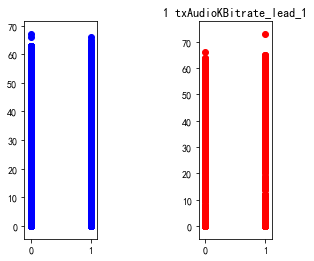

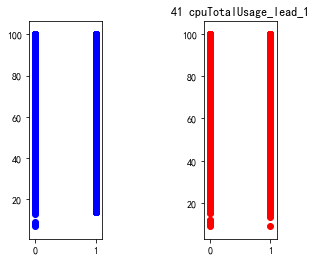

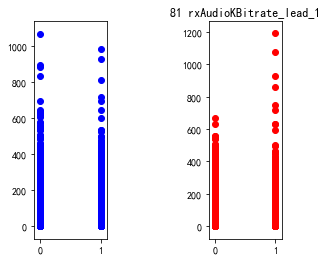

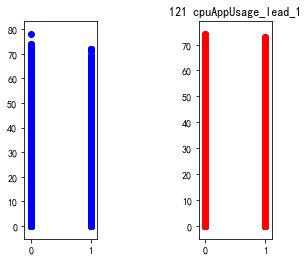

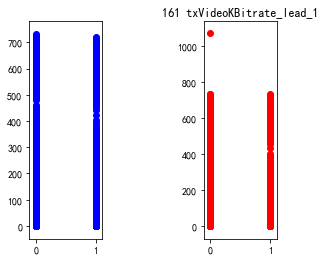

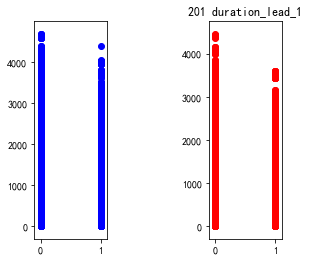

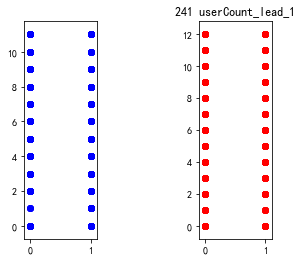

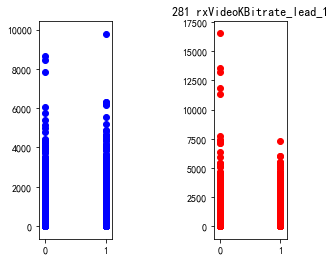

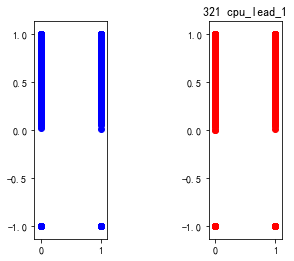

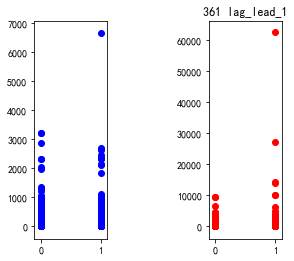

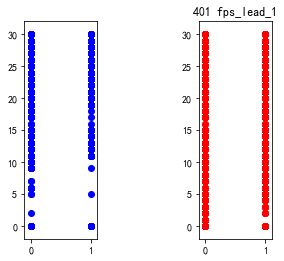

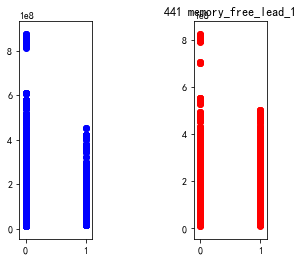

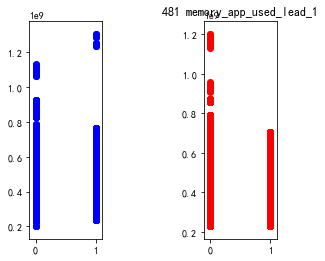

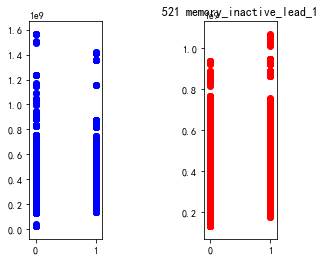

In [9]:
#看前后40秒不同类(2)数据趋势
for i in range(1,561):
    if i%40==1:
        plt.subplot(141)
        for j in range(0,40):
            plt.scatter(df.iloc[:,-1], df.iloc[:,i+j], color='b')
        plt.subplot(143)
        for j in range(0,40):
            plt.scatter(df.iloc[:,-1], df.iloc[:,560+i+j], color='R')
        plt.title('%d %s' %(i,a_col[i]))
        plt.show()

In [10]:
#依据上面图的变化趋势，剔除变化不明显的变量。
df1=df.copy()
for i in range(1,1121):
    if a_col[i][0:2]=='cp'or a_col[i][0:2]=='us'or a_col[i][0:2]=='tx':
        df1.drop(a_col[i],axis=1, inplace=True)
df1=df1.reset_index(drop = True)
print(df1.shape)

(4896, 642)


In [11]:
#构建特征
import numpy as np
df2=df1[['type']]
df2['class']=df1['class']
df1_columns=df1.columns.values
for i in range(1,641):
    if i%40==1:
        i1=df1_columns[i][:-1]+'975'
        i2=df1_columns[i][:-1]+'525'
        i3=df1_columns[i][:-1]+'avg'
        i4=df1_columns[i][:-1]+'std'
        temp_975i=[]
        temp_525i=[]
        temp_avgi=[]
        temp_stdi=[]
        for j in range(0,len(df1)):
            temp_array=np.array(df1.iloc[j,i:i+40])
            j_975=np.percentile(temp_array,90)-np.percentile(temp_array,75)
            temp_975i.append(j_975)
            j_525=np.percentile(temp_array,25)-np.percentile(temp_array,5)
            temp_525i.append(j_525)
            temp_avgi.append(np.mean(temp_array))
            temp_stdi.append(np.std(temp_array))       
        df2[i1]=temp_975i
        df2[i2]=temp_525i
        df2[i3]=temp_avgi
        df2[i4]=temp_stdi

d:\al\python\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\DELL\AppData\Roaming\Python\Python37\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
d:\al\python\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
d:\al\python\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

In [12]:
# Split Training Set from Testing Set (70/30)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

df2.dropna(axis=0, how='any',inplace=True)
x=df2.iloc[:,2:]
y=df2.iloc[:,1]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
#随机取数
cv = ShuffleSplit(n_splits=20, test_size=0.3)
# 建立模型
rf = RandomForestClassifier()
#设置参数变化
rf_param = {'n_estimators': range(1,11)}
#网格搜索寻找最优参数
rf_grid = GridSearchCV(rf, rf_param, cv=cv)
rf_grid.fit(x_train, y_train)
print('Parameter with best score:')
print('rf_grid.best_params_')
print('cross validation score:', rf_grid.best_score_)

d:\al\python\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Parameter with best score:
rf_grid.best_params_
cross validation score: 0.8904203323558162


In [13]:
best_rf = rf_grid.best_estimator_
print('Test score:', best_rf.score(x_test, y_test))

Test score: 0.8885088919288646
